## Principal Moments of Inertia

In [ ]:
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandarallel import pandarallel
from rdkit import Chem
from rdkit.Chem import PandasTools, rdDistGeom, rdForceFieldHelpers, rdMolDescriptors

In [2]:
BASE_PATH = os.path.dirname(os.getcwd())

In [3]:
files = [f for f in os.listdir(os.path.join(BASE_PATH, "data", "processed")) 
         if f.endswith("cleaned.csv")]
files

['compounds_GreinerL_cleaned.csv',
 'chembl_35_NP_cleaned.csv',
 'enamine_advanced_50k_subset_cleaned.csv',
 'drugbank_5_1_13_cleaned.csv']

In [ ]:
# def generate_3d(mol, random_state):
#     s = Chem.SanitizeMol(mol, catchErrors=True)
#     if s != 0:
#         return None
#     mh = Chem.AddHs(mol)
#     id = rdDistGeom.EmbedMolecule(mh, randomSeed=random_state)
#     if id == -1:
#         # from https://github.com/rdkit/rdkit/issues/1433
#         id = rdDistGeom.EmbedMolecule(mh, randomSeed=random_state, useRandomCoords=True)
#     if id == -1:
#         return None
#     res = 10
#     ntries = -1
#     iters = [100, 300, 1000]
#     while res > 0 and ntries < 3:
#         res = rdForceFieldHelpers.UFFOptimizeMolecule(mh, maxIters=iters[ntries])
#         ntries += 1

#     if res == 0:
#         return mh
#     return None

In [4]:
import logging
from io import StringIO
from rdkit import rdBase


rdBase.LogToPythonLogger()
logger = logging.getLogger("rdkit")
logger.handlers[0].setLevel(logging.WARN)
logger_sio = StringIO()
handler = logging.StreamHandler(logger_sio)
handler.setLevel(logging.INFO)
logger.addHandler(handler)


def get_message():
    text = logger_sio.getvalue()
    logger_sio.truncate(0)
    logger_sio.seek(0)
    if text:
        return text
    return ""


def generate_3d(mol, random_state):
    messages = []
    s = Chem.SanitizeMol(mol, catchErrors=True)
    messages.append(get_message())
    if s != 0:
        return None, messages
    mh = Chem.AddHs(mol)
    id = rdDistGeom.EmbedMolecule(mh, randomSeed=random_state)
    messages.append(get_message())
    if id == -1:
        # from https://github.com/rdkit/rdkit/issues/1433
        id = rdDistGeom.EmbedMolecule(mh, randomSeed=random_state, useRandomCoords=True)
        messages.append(get_message())
    if id == -1:
        return None, messages
    messages.append("")
    res = 10
    ntries = -1
    iters = [100, 300, 1000]
    while res > 0 and ntries < 3:
        res = rdForceFieldHelpers.UFFOptimizeMolecule(mh, maxIters=iters[ntries])
        ntries += 1
    messages.append(get_message())

    if res == 0:
        return mh, messages
    return None, messages

In [6]:
def calc_pmi(mol, replicates=3):
    npr1 = []
    npr2 = []
    for rdst in [2025 + 3 * i for  i in range(replicates)]:
        m, msg = generate_3d(mol, rdst)  
        if m is not None:
            npr1.append(rdMolDescriptors.CalcNPR1(m))
            npr2.append(rdMolDescriptors.CalcNPR2(m))
        else:
            return np.nan, np.nan
    return np.median(npr1), np.median(npr2)

In [7]:
def get_pmis(filepath):
    df = pd.read_csv(filepath)
    PandasTools.AddMoleculeColumnToFrame(df, smilesCol="taut_smiles")
    if len(df) > 1000:
        pandarallel.initialize(nb_workers=24, progress_bar=True)
        res = df["ROMol"].parallel_apply(calc_pmi)
        df[["NPR1", "NPR2"]] = pd.DataFrame(res.tolist(), index=df.index)
    else:
        df[["NPR1", "NPR2"]] = df["ROMol"].apply(calc_pmi).apply(pd.Series)
    cols = [df.columns[0]] + ["NPR1", "NPR2"]
    return df[cols]


In [8]:
start = time.time()
for file in files:
    name = file.split("_")[0]
    path = os.path.join(BASE_PATH, "data", "processed", file)
    df = get_pmis(path)
    df.insert(1, "dataset", [name] * len(df))
    df.rename(columns={df.columns[0]: "ID"}, inplace=True)
    df.to_csv(os.path.join(BASE_PATH, "reports", f"PMIs_{name}.csv"),
                index=False)

end = time.time()

print(f"Total execution time: {end - start :.2f} s")

INFO: Pandarallel will run on 24 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


[15:48:56] UFFTYPER: Unrecognized charge state for atom: 16
[15:48:56] UFFTYPER: Unrecognized charge state for atom: 16
[15:48:56] UFFTYPER: Unrecognized charge state for atom: 16
[15:48:56] UFFTYPER: Unrecognized charge state for atom: 16
[15:48:56] UFFTYPER: Unrecognized charge state for atom: 16
[15:48:56] UFFTYPER: Unrecognized charge state for atom: 16
[15:49:32] UFFTYPER: Unrecognized charge state for atom: 1
[15:49:32] UFFTYPER: Unrecognized charge state for atom: 1
[15:49:32] UFFTYPER: Unrecognized charge state for atom: 1
[15:49:32] UFFTYPER: Unrecognized charge state for atom: 1
[15:49:32] UFFTYPER: Unrecognized charge state for atom: 1
[15:49:32] UFFTYPER: Unrecognized charge state for atom: 1
[15:49:46] UFFTYPER: Unrecognized charge state for atom: 3
[15:49:46] UFFTYPER: Unrecognized charge state for atom: 3
[15:49:46] UFFTYPER: Unrecognized charge state for atom: 3
[15:49:46] UFFTYPER: Unrecognized charge state for atom: 3
[15:49:46] UFFTYPER: Unrecognized charge state for

INFO: Pandarallel will run on 24 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


[20:20:37] UFFTYPER: Unrecognized charge state for atom: 1
[20:20:37] UFFTYPER: Unrecognized charge state for atom: 1
[20:20:37] UFFTYPER: Unrecognized charge state for atom: 1
[20:20:37] UFFTYPER: Unrecognized charge state for atom: 1
[20:20:37] UFFTYPER: Unrecognized charge state for atom: 1
[20:20:37] UFFTYPER: Unrecognized charge state for atom: 1
[20:20:43] UFFTYPER: Unrecognized charge state for atom: 4
[20:20:43] UFFTYPER: Unrecognized charge state for atom: 4
[20:20:43] UFFTYPER: Unrecognized charge state for atom: 4
[20:20:43] UFFTYPER: Unrecognized charge state for atom: 4
[20:20:43] UFFTYPER: Unrecognized charge state for atom: 4
[20:20:43] UFFTYPER: Unrecognized charge state for atom: 4
[20:20:45] UFFTYPER: Unrecognized charge state for atom: 13
[20:20:45] UFFTYPER: Unrecognized charge state for atom: 13
[20:20:45] UFFTYPER: Unrecognized charge state for atom: 13
[20:20:45] UFFTYPER: Unrecognized charge state for atom: 13
[20:20:45] UFFTYPER: Unrecognized charge state for a

INFO: Pandarallel will run on 24 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


[20:32:20] UFFTYPER: Unrecognized charge state for atom: 16
[20:32:20] UFFTYPER: Unrecognized charge state for atom: 16
[20:32:20] UFFTYPER: Unrecognized charge state for atom: 12
[20:32:20] UFFTYPER: Unrecognized charge state for atom: 12
[20:32:20] UFFTYPER: Unrecognized charge state for atom: 12
[20:32:20] UFFTYPER: Unrecognized charge state for atom: 12
[20:32:20] UFFTYPER: Unrecognized charge state for atom: 12
[20:32:20] UFFTYPER: Unrecognized charge state for atom: 12
[20:32:20] UFFTYPER: Unrecognized charge state for atom: 16
[20:32:21] UFFTYPER: Unrecognized charge state for atom: 16
[20:32:21] UFFTYPER: Unrecognized charge state for atom: 16
[20:32:21] UFFTYPER: Unrecognized charge state for atom: 16
[20:32:24] UFFTYPER: Unrecognized charge state for atom: 1
[20:32:24] UFFTYPER: Unrecognized charge state for atom: 1
[20:32:24] UFFTYPER: Unrecognized charge state for atom: 1
[20:32:24] UFFTYPER: Unrecognized charge state for atom: 1
[20:32:24] UFFTYPER: Unrecognized charge sta

Total execution time: 18215.31 s


In [ ]:
results_files = [f for f in os.listdir(os.path.join(BASE_PATH, "reports")) 
                 if f.startswith("PMIs")]

pmis = []
for f in results_files:
    filepath = os.path.join(BASE_PATH, "reports", f)
    df = pd.read_csv(filepath)
    pmis.append(df)

pmis = pd.concat(pmis, axis=0)
pmis.shape

(139466, 4)

In [11]:
pmis.to_csv(os.path.join(BASE_PATH, "reports", "PMIs.csv"),
            index=False)

In [77]:
pmis = pd.read_csv(os.path.join(BASE_PATH, "reports", "PMIs.csv"))

In [78]:
order = {}
for name, group in pmis.groupby("dataset"):
    l = pmis.dataset.apply(len).max() + 1
    print(f"{name :10}: {len(group)}")
    order[name] = len(group)

order = {k: v for k, v in sorted(order.items(), key=lambda item: item[1], reverse=True)}

order

chembl    : 78163
compounds : 22
drugbank  : 11307
enamine   : 49974


{'chembl': 78163, 'enamine': 49974, 'drugbank': 11307, 'compounds': 22}

In [13]:
import matplotlib.pyplot as plt

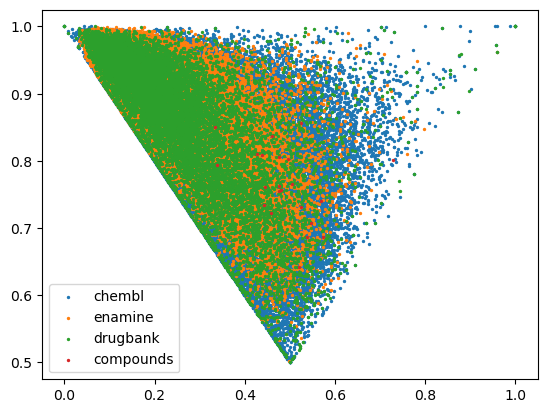

In [79]:
fig = plt.figure()
ax = fig.add_subplot()
for data in order.keys():
        idx = pmis.query("dataset == @data").index
        ax.scatter(pmis["NPR1"].loc[idx], pmis["NPR2"].loc[idx], s=2, label=data)

plt.legend()
plt.show()

In [80]:
from scipy.stats import gaussian_kde

t = pmis.query("dataset == 'enamine'")[["NPR1", "NPR2"]].copy()
t.dropna(axis=0, inplace=True)
dens = gaussian_kde(t.transpose())

x = np.linspace(0, 1, 100)
y = np.linspace(0, 1, 100)
xx, yy = np.meshgrid(x, y)
xy = np.vstack((xx.flatten(), yy.flatten()))
z = dens.evaluate(xy).reshape(xx.shape)


In [81]:
z[25, 98]

np.float64(2.548305892737707e-165)

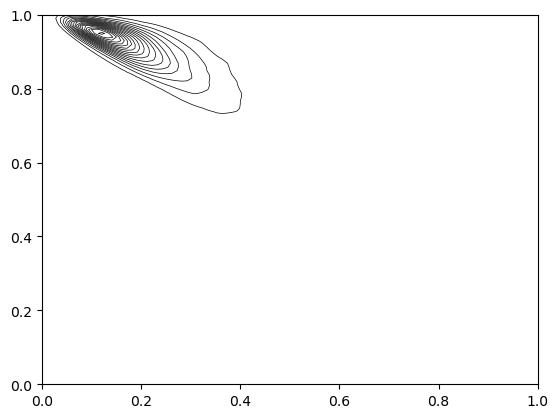

In [82]:
# plt.scatter(t["NPR1"], t["NPR2"], s=1, alpha=0.5)
plt.contour(x, y, z, levels=20, colors='k', linewidths=0.5, vmin=1e-3, extend="min")
# plt.contourf(x, y, z, levels=20, cmap="RdBu_r", vmin=0.5)

plt.show()

In [83]:
from scipy.stats import gaussian_kde

t = pmis.query("dataset == 'enamine'")[["NPR1", "NPR2"]].copy()
t.dropna(axis=0, inplace=True)

X, Y = np.mgrid[0:1:100j, 0:1:100j]
positions = np.vstack((X.ravel(), Y.ravel()))
values = t.transpose()
kernel = gaussian_kde(values)

Z = np.reshape(kernel(positions).T, X.shape)

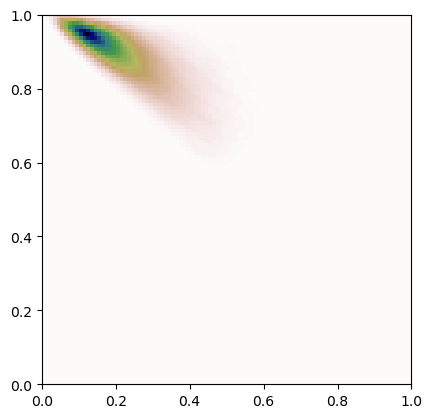

In [84]:
fig, ax = plt.subplots()
ax.imshow(np.rot90(Z), cmap=plt.cm.gist_earth_r,
          extent=[0, 1, 0, 1])
# ax.plot(t["NPR1"], t["NPR2"], 'k.', markersize=0.02)

plt.show()

In [85]:
Z.max()

np.float64(73.52512719976664)

/tmp/ipykernel_1095638/3914667751.py:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


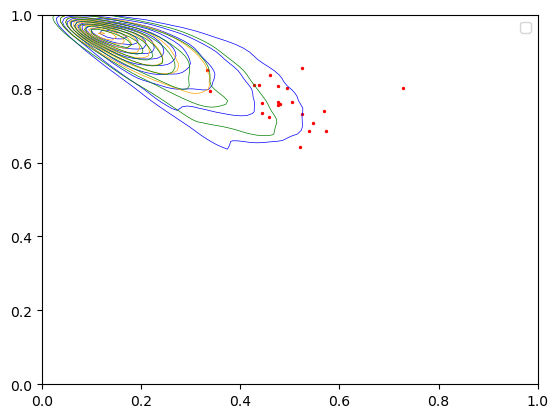

In [ ]:
colors = {
    'chembl': "blue", 'enamine': "orange", 'drugbank': "green", 'compounds': "red"
}

fig = plt.figure()
ax = fig.add_subplot()
for data in order.keys():
    idx = pmis.query("dataset == @data").index
    if data == "compounds":
        ax.scatter(pmis["NPR1"].loc[idx], pmis["NPR2"].loc[idx], s=2, c=colors[data])
    else:
        t = pmis[["NPR1", "NPR2"]].iloc[idx].copy()
        t.dropna(axis=0, inplace=True)
        
        X, Y = np.mgrid[0:1:100j, 0:1:100j]
        positions = np.vstack((X.ravel(), Y.ravel()))
        kernel = gaussian_kde(t.transpose())
        Z = np.reshape(kernel(positions), X.shape)
        ax.contour(X, Y, Z, levels=10, colors=colors[data], linewidths=0.5, vmin=1e-3, extend="min")

# plt.legend()
plt.show()

In [89]:
densities = {}
for data in order.keys():
    if data != "compounds":
        idx = pmis.query("dataset == @data").index
        t = pmis[["NPR1", "NPR2"]].iloc[idx].copy()
        t.dropna(axis=0, inplace=True)
        
        X, Y = np.mgrid[0:1:100j, 0:1:100j]
        positions = np.vstack((X.ravel(), Y.ravel()))
        kernel = gaussian_kde(t.transpose())
        Z = np.reshape(kernel(positions), X.shape)
        densities[data] = (X, Y, Z)

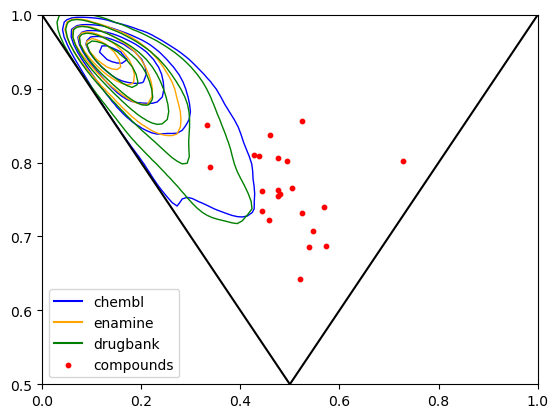

In [101]:
from matplotlib.lines import Line2D

colors = {
    'chembl': "blue", 'enamine': "orange", 'drugbank': "green", 'compounds': "red"
}

fig = plt.figure()
ax = fig.add_subplot()
elements = []
for data in order.keys():
    if data == "compounds":
        idx = pmis.query("dataset == @data").index
        pt = ax.scatter(pmis["NPR1"].loc[idx], pmis["NPR2"].loc[idx], s=10, c=colors[data])
        elements.append(pt)
    else:
        X, Y, Z = densities[data]
        ax.contour(X, Y, Z, levels=5, colors=colors[data], linewidths=1, vmin=1e-3, extend="min")
        elements.append(Line2D([], [], color=colors[data]))

ax.axline((0, 1), (0.5, 0.5), color="k")
ax.axline((0.5, 0.5), (1, 1), color="k")

ax.set_ylim((0.5, 1))

plt.legend(elements, list(order.keys()))
plt.show()

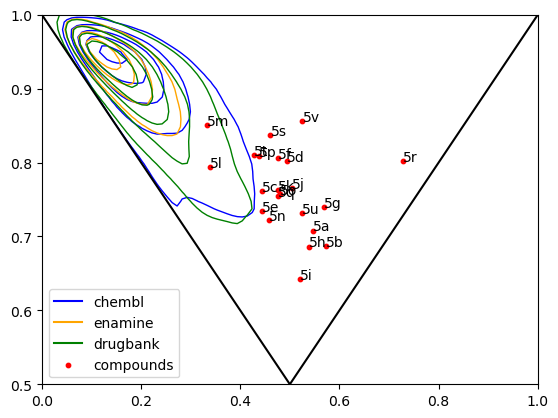

In [ ]:
from matplotlib.lines import Line2D

colors = {
    'chembl': "blue", 'enamine': "orange", 'drugbank': "green", 'compounds': "red"
}

fig = plt.figure()
ax = fig.add_subplot()
elements = []
for data in order.keys():
    if data == "compounds":
        idx = pmis.query("dataset == @data").index
        pt = ax.scatter(pmis["NPR1"].loc[idx], pmis["NPR2"].loc[idx], s=10, c=colors[data])
        elements.append(pt)
        for i in idx:
            ax.annotate(pmis["ID"].loc[i], (pmis["NPR1"].loc[i], pmis["NPR2"].loc[i]), )
    else:
        X, Y, Z = densities[data]
        ax.contour(X, Y, Z, levels=5, colors=colors[data], linewidths=1, vmin=1e-3, extend="min")
        elements.append(Line2D([], [], color=colors[data]))

ax.axline((0, 1), (0.5, 0.5), color="k")
ax.axline((0.5, 0.5), (1, 1), color="k")

ax.set_ylim((0.5, 1))

plt.legend(elements, list(order.keys()))
plt.show()

In [9]:
from rdkit.Chem import rdDistGeom

ps = rdDistGeom.srETKDGv3()
ps.numThreads = 6
ps.randomSeed = 2025
ps.pruneRmsThresh = 0.5

for m in mols:
    rdDistGeom.EmbedMultipleConfs(m, 100, ps)

[16:48:01] UFFTYPER: Unrecognized charge state for atom: 1


In [ ]:
import numpy as np
from rdkit.Chem import Descriptors3D

res = []
for m in mols:
    confs = m.GetConformers()
    d = []
    for conf in confs:
        d.append([Descriptors3D.NPR1(m, confId=conf.GetId()),
                  Descriptors3D.NPR2(m, confId=conf.GetId())])
    res.append(np.array(d))

In [11]:
res[0].shape

(100, 2)

In [12]:
for r in res:
    print(len(r))

100
20
100
23
100
3


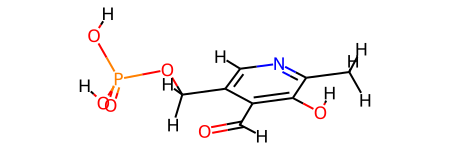

In [13]:
mols[1]

In [18]:
mh = Chem.AddHs(tmp["ROMol"][1])
rdDistGeom.EmbedMolecule(mh, rdDistGeom.srETKDGv3())

0

In [15]:
from rdkit.Chem import rdForceFieldHelpers
s = rdForceFieldHelpers.UFFOptimizeMolecule(mh, maxIters=300)
print(s)

0


In [16]:
s

0

In [ ]:
rdDistGeom.EmbedMultipleConfs(mh, 100, ps)

s2 = rdForceFieldHelpers.UFFOptimizeMoleculeConfs(mh, maxIters=1000, numThreads=6)
for x in s2:
    print(x)

(0, 26.341386369454263)
(0, 25.123093748586438)
(0, 26.34138633303018)
(0, 30.95674841466994)
(0, 27.582007251687628)
(0, 26.851160036601797)
(0, 27.86795888381259)
(0, 28.02262238605056)
(0, 26.362235468277888)
(0, 30.06000350933779)
(0, 28.267056718832666)
(0, 29.098759905133583)
(0, 25.269005992844892)
(0, 29.970325052035427)
(0, 30.471506418680715)
(0, 30.497966024746795)
(0, 27.10322078885603)
(0, 29.19017574115091)
(0, 28.095484530598544)
(0, 30.827100193646338)


In [24]:
s2.index(min(s2))

1

In [25]:
min_val = s2[1][1]

In [31]:
rel_e = []
for i, x in enumerate(s2):
    rel_e.append((i, x[1] - min_val))

In [32]:
sorted(rel_e, key=lambda x: x[1])

[(1, 0.0),
 (12, 0.1459122442584544),
 (2, 1.2182925844437413),
 (0, 1.2182926208678246),
 (8, 1.2391417196914496),
 (5, 1.7280662880153592),
 (16, 1.9801270402695934),
 (4, 2.45891350310119),
 (6, 2.744865135226153),
 (7, 2.8995286374641225),
 (18, 2.9723907820121056),
 (10, 3.1439629702462284),
 (11, 3.9756661565471454),
 (17, 4.0670819925644714),
 (13, 4.847231303448989),
 (9, 4.936909760751352),
 (14, 5.348412670094277),
 (15, 5.374872276160357),
 (19, 5.7040064450599),
 (3, 5.8336546660835005)]